In [1]:
# prepare data for lstm
from pandas import read_pickle
from math import sqrt
from numpy import concatenate
import tensorflow as tf
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
import numpy as np
import pandas as pandas
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

In [2]:
desired_width=320

pandas.set_option('display.width', desired_width)
pandas.set_option('display.max_columns',7)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def plot_dataset(values,dataset):
    groups = [0,1,2,3,4]
    i = 1
    pyplot.figure()
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
    pyplot.show()

In [5]:
def split_data(dataset):
    # split into train and test sets
    values = dataset.values
    train = values[:split_point, :]
    test = values[split_point:, :]

    return train,test

In [6]:
def input_output(dataset,features,time_steps_lag, time_steps):
    # split into input and outputs
    train, test = split_data(dataset)
    n_obs = features * time_steps_lag
    train_X, train_y = train[:, :n_obs], train[:,n_obs+features*(time_steps+1)-1]
    test_X, test_y = test[:, :n_obs], test[:, n_obs+features*(time_steps+1)-1]
    
    return train_X, train_y, test_X, test_y, n_obs

In [7]:
def reshape_input(train_X, test_X):
    train_X = train_X.reshape((train_X.shape[0], time_steps_lag, features))
    test_X = test_X.reshape((test_X.shape[0], time_steps_lag, features))
    return train_X , test_X

In [8]:
def design_network(train_X,hiddenlayer1, hiddenlayer2,):
    model = Sequential()
    model.add(GRU(hiddenlayer1, return_sequences = True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(GRU(hiddenlayer2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model


In [9]:
def fit_network(model,batch, epoch, number):
    history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch,
                        verbose=2, shuffle=False)
    if x == 1:
        ax1.plot(history.history['loss'], label = 'Training')
        ax1.set_title(f"Loss of t+{number}")
        ax1.set(ylabel = "MSE",xlabel="Epochs")
    else:
        axs[number-start_time_step,0].plot(history.history['loss'], label = 'Training')
        axs[number-start_time_step,0].set_title(f"Loss of t+{number}")
        axs[number-start_time_step,0].set(ylabel = "MSE")
        if number == last_time_step -1:
            axs[number - start_time_step, 0].set(xlabel="Epochs")
    return model

In [10]:
def create_prediction_graph(model, test_X, test_y, time_steps_lag, features):
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], time_steps_lag * features))
    # invert scaling for forecast
    inv_yhat = concatenate((test_X[:, -features:-1], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:, features-1]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate(( test_X[:, -features:-1], test_y,), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, features-1]
    mean_true_y = np.full((len(inv_y),1),inv_y.mean())

    NSE = 1 - mean_squared_error(inv_y, inv_yhat)/mean_squared_error(inv_y, mean_true_y)
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    return  rmse, inv_y, inv_yhat , NSE

In [11]:
def create_subplot(i,start_time_step,true_y,predict_y,rmse,NSE,last_time_step):
    if x == 1:
        ax2.plot(true_y, label = "True", alpha = 1)
        ax2.plot(predict_y, label = "Prediction", alpha = 0.7)
        ax2.set_title(f"Graph t+{i}  RMSE: {round(rmse, 4)} NSE: {round(NSE,4)}")
        ax2.set(xlabel = "Instances", ylabel = "MNAP")
    else:
        axs[i-start_time_step,1].plot(true_y, label = "True", alpha = 1)
        axs[i-start_time_step,1].plot(predict_y, label = "Prediction", alpha = 0.7)
        axs[i-start_time_step,1].set_title(f"Graph t+{i}  RMSE: {round(rmse, 4)} NSE: {round(NSE,4)}")
        axs[i - start_time_step, 1].set(ylabel="mNAP")
        if i == last_time_step -1:
            axs[i - start_time_step, 1].set(xlabel = "Instances", ylabel = "MNAP")

In [12]:
# load dataset
train_data = read_pickle("TRAIN LSTM Pickle Hourly incl knmi.pkl")
test_data = read_pickle("TEST LSTM Pickle Hourly incl knmi.pkl")
split_point = len(train_data)
dataset = pandas.concat([train_data, test_data])

In [13]:
print(dataset[1:])

                      Time  Rainfall Appelweg (radar Hydronet)  Rainfall Buikslotermeerplein (radar Hydronet)  ...      knmi5      knmi6      knmi7
1      2016-01-02 10:00:00                                 0.0                                            0.0  ...   0.306396   0.306396   0.307129
2      2016-01-02 11:00:00                                 0.0                                            0.0  ...   0.306396   0.307129   0.327881
3      2016-01-02 12:00:00                                 0.0                                            0.0  ...  0.0126953  0.0622559   0.214844
4      2016-01-02 13:00:00                                 0.0                                            0.0  ...  0.0622559   0.214844   0.215332
5      2016-01-02 14:00:00                                 0.0                                            0.0  ...   0.214844   0.215332   0.216797
...                    ...                                 ...                                            ...  .

In [14]:
# Move feature to be predicted to end of dataset and use time as index column
dataset = dataset.set_index("Time")
dataset = dataset.pop("BBB sewer")
result = pandas.concat([dataset], axis =1)
dataset = result

In [17]:
# Drop features from dataset
dataset = dataset.drop(columns=["knmi1","knmi2","knmi3","knmi4","knmi5","knmi6","knmi7"])
values_train = train_data.values
values_train2 = values_train.set_index("Time")
values_train4 = pandas.concat([values_train2], axis=1)
values_train = values_train4
values_train = values_train.astype('float32')
# Ensure all data is float
values = dataset.values
values = values.astype('float32')

KeyError: "['knmi1' 'knmi2' 'knmi3' 'knmi4' 'knmi5' 'knmi6' 'knmi7'] not found in axis"

In [18]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit(values_train)
scaled = scaled.transform(values)

NameError: name 'values_train' is not defined

In [19]:
## initialize variables

#How many time steps in the future the model should train on
# 1 model trained per time step, so univariate output,
# not 1 model trained on 6 time steps (multivariate output)
# if last_time_step = 2, model for t and t+1 will be trained
# range[1:]
last_time_step = 6

In [20]:
#From which time step in the future it will start training on range[0:last_time_step-1]

start_time_step = 5

In [21]:
#How many time steps in the past should be given as an extra feature range[1:]
time_steps_lag = 6

In [22]:
#Amount of input features including feature to be predicted
features = len(dataset.columns)

In [23]:
#output shape of GRU layer, terminology inconsistent can be called amount of units/neurons/hiddenlayers
hiddenlayer1 = 320
hiddenlayer2 = 128

In [24]:
#How many instances the GRU will go through before it updates it's weights. Too small batch size leads to overfitting
batch_size = 1000

In [25]:
#How often to go through the whole dataset
epoch = 10

In [26]:
# create supervised dataset with past- and future time steps
reframed = series_to_supervised(scaled, time_steps_lag, last_time_step)

NameError: name 'scaled' is not defined

In [27]:
#option to plot whole dataset for visualization
#plot_dataset(values, dataset)

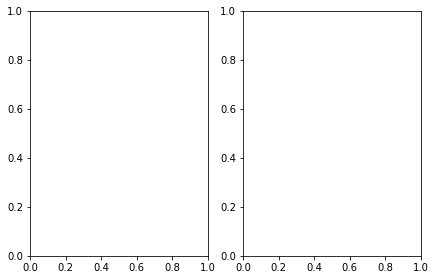

In [28]:
#Create figure with corresponding subplots. Can't have input of single timestep, will be fixed later
x = last_time_step - start_time_step
if x == 1:
    figure, (ax1,ax2) = plt.subplots(1, 2, sharex= "col", sharey ="col", figsize=(7,4.5))
else:
    figure, axs = plt.subplots(x,2, sharex= "col", sharey ="col", figsize=(10,6.5))

In [29]:
#train, fit, plot loss, plot prediction for every time step
for i in range(start_time_step,last_time_step):
    train_X, train_y, test_X, test_y, n_obs = input_output(reframed, features, time_steps_lag, i)
    train_X, test_X = reshape_input(train_X, test_X)
    model = design_network(train_X,hiddenlayer1,hiddenlayer2)
    model = fit_network(model, batch_size, epoch,i)
    rmse, true_y, predict_y, NSE = create_prediction_graph(model, test_X, test_y, time_steps_lag, features)
    #compute in prediction subplot
    create_subplot(i,start_time_step,true_y,predict_y,rmse,NSE,last_time_step)
    print('test RMSE: %.3f' % rmse)
    print('test NSE: %.3f' % NSE)

NameError: name 'reframed' is not defined

In [30]:
#
if x == 1:
    ax1.legend()
    ax1.legend()
else:
    axs[0, 0].legend()
    axs[0, 1].legend()
figure.suptitle("Prediction and Loss Including KNMI-forecast")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
